In [1]:
%cd ..

/home/tianshu/prediction


In [2]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from jax import numpy as jnp
from jax import vmap

from forecast import Dataset, Results

In [3]:
ds = Dataset("data.npz", if_data="if.npz", offset=1000. * 1000.)
results = Results(
    ds, base_dir="results", manifest="results/manifest.json",
    baseline_key="Lr8")

  0%|          | 0/35 [00:00<?, ?it/s]

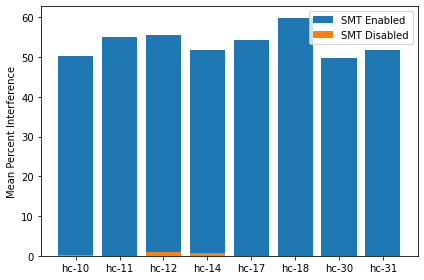

In [79]:
_smt_runtimes = [
    'hc-10', 'hc-11', 'hc-12', 'hc-14', 'hc-17', 'hc-18', 'hc-30', 'hc-31']
    
def _mean_interference(df):
    return [
        np.mean(np.exp(df[df["runtime"] == rt]["diff"]) - 1) * 100
        for rt in _smt_runtimes]


def _interference_smt():
    if_smt = _mean_interference(pd.read_csv("data/if.csv"))
    if_multicore = _mean_interference(pd.read_csv("data/if.mc.csv"))

    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.bar(np.arange(8), if_smt, label="SMT Enabled")
    ax.bar(np.arange(8), np.maximum(0, if_multicore), label="SMT Disabled")
    ax.legend()
    ax.set_ylabel("Mean Percent Interference")
    ax.set_xticks(np.arange(8))
    ax.set_xticklabels(_smt_runtimes)
    fig.tight_layout()
    fig.savefig("figures/interference_smt.png", dpi=300)

_interference_smt()

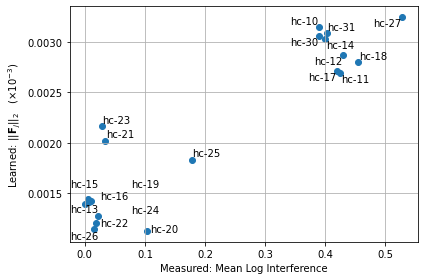

In [ ]:
from adjustText import adjust_text

# Interference Magnitude
# L2 matrix norm is max_{m_i, m_k} m_i^TF_jm_k, i.e. the maximum possible
# interference achieved by a pair of modules in our embedding space.

def _interference_magnitude():

    def spectral_norm(v_s, v_g):
        return jnp.linalg.norm(jnp.matmul(v_s, v_g.T))

    vvv = vmap(vmap(vmap(spectral_norm)))
    res = np.load("results/Is1/0.9.npz")
    norms = jnp.mean(vvv(res["V_s"], res["V_g"]), axis=(0, 1))

    df = pd.read_csv("data/if.csv")
    mean_interference = np.array(df.groupby("runtime")["diff"].mean())

    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.scatter(mean_interference, norms)
    ax.set_ylabel(r"Learned: $||\mathbf{F}_j||_2 \quad (\times 10^{-3})$")
    ax.set_xlabel("Measured: Mean Log Interference")
    ax.grid(visible=True)

    adjust_text([
        ax.text(x, y, rt) for x, y, rt in
        zip(mean_interference, norms, ds.runtimes)])

    fig.tight_layout()
    fig.savefig("figures/interference_interp.png", dpi=300)

_interference_magnitude()

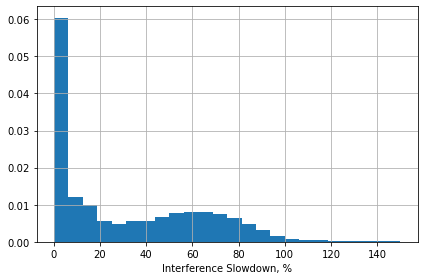

In [ ]:
# Interference Histogram

def _interference_histogram():
    df = pd.read_csv("data/if.csv")
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.hist(
        100 * (np.exp(df["diff"]) - 1),
        bins=np.linspace(0, 150, 25), density=True)
    ax.set_xlabel("Interference Slowdown, %")
    ax.grid()
    fig.tight_layout()
    fig.savefig("figures/interference_hist.png", dpi=300)

_interference_histogram()

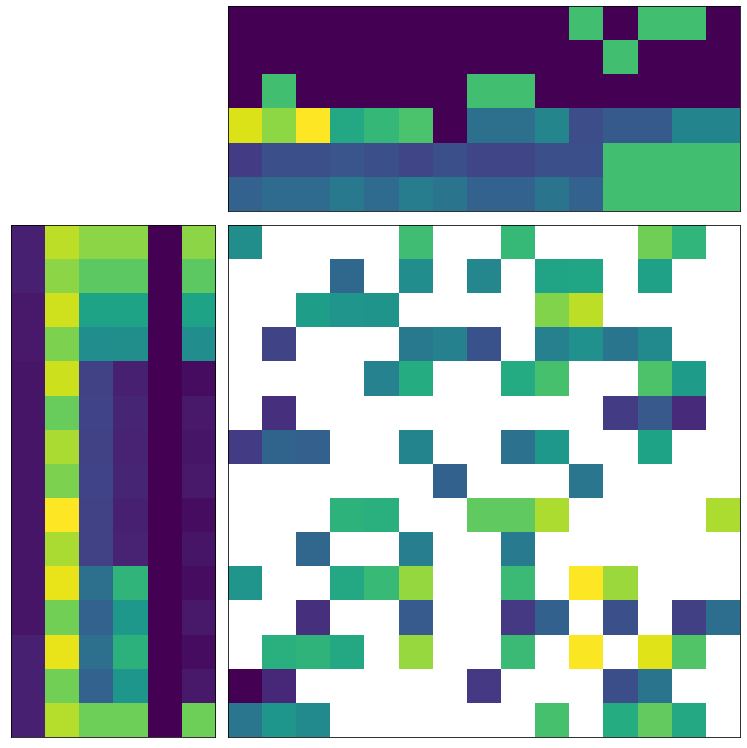

In [67]:
# Matrix Completion

def _matrix_completion():
    ds = Dataset("data/data.npz", if_data="data/if.npz", offset=1000. * 1000.)

    mat = ds.matrix[30:45, 0:15]
    random_mask = np.random.rand(*mat.shape) > 0.4
    mat = np.ma.masked_where(random_mask == 1, mat)
    cmap = matplotlib.cm.viridis.copy()
    cmap.set_bad(color='white')

    fig = plt.figure(figsize=(21 / 2, 21 / 2))
    gs = matplotlib.gridspec.GridSpec(
        2, 2, width_ratios=[6 / 21, 15 / 21], height_ratios=[6 / 21, 15 / 21])

    matrix = plt.subplot(gs[1, 1])
    matrix.imshow(mat, cmap=cmap)
    module = plt.subplot(gs[1, 0])
    module.imshow(ds.x_m[30:45, 60:66])
    X = ds.x_d.T[np.array([1, 3, 5, 12, 14, 15]), :15]
    device = plt.subplot(gs[0, 1])
    device.imshow(np.concatenate([X[:-2], 1 + X[-2:] / 20]))

    for ax in [module, matrix, device]:
        ax.set_xticks([])
        ax.set_yticks([])

    fig.tight_layout()
    fig.savefig("figures/matrix_completion.png", dpi=300, bbox_inches='tight')

_matrix_completion()

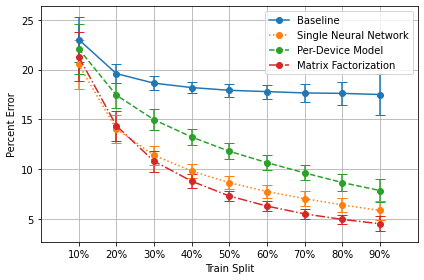

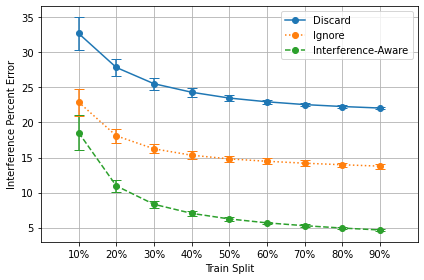

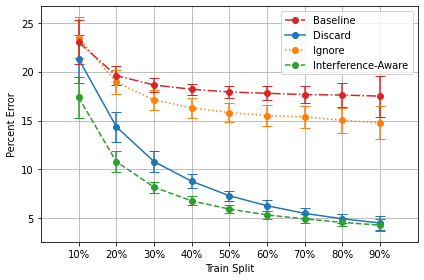

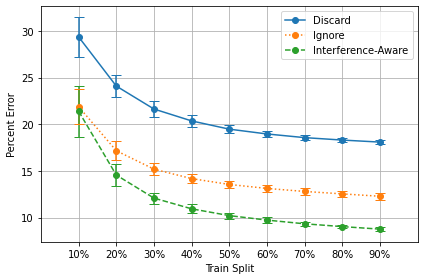

In [ ]:
# Comparisons

def _method_comparisons():

    fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    results.plots(
        ["naive_mlp", "device_mlp", "Er64"], ax=axs,
        boxplot=False, baseline=True,
        key="error", fmt=["o:", "o--", "o-.", "o-"], labels={
            "Er64": "Matrix Factorization",
            "device_mlp": "Per-Device Model",
            "naive_mlp": "Single Neural Network"})
    fig.tight_layout()
    fig.savefig("figures/non-interference.png", dpi=300)

    fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    results.plots(
        ["Er64", "ignore", "Is1"], ax=axs, boxplot=False,
        baseline=False, key="interference", labels={
            "Er64": "Discard",
            "ignore": "Ignore",
            "Is1": "Interference-Aware"
        }, fmt=["o-", "o:", "o--"])
    axs.set_ylabel("Interference Percent Error")
    fig.tight_layout()
    fig.savefig("figures/interference.png", dpi=300)

    fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    results.plots(
        ["Er64", "ignore", "Is1"], ax=axs, boxplot=False,
        baseline='C3', key="error", labels={
            "Er64": "Discard", "Is1": "Interference-Aware",
            "ignore": "Ignore"
        }, fmt=["o-", "o:", "o--", "o-."], colors=['C0', 'C1', 'C2', 'C3'])
    fig.tight_layout()
    fig.savefig("figures/interference_error.png", dpi=300)

    fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    results.plots(
        ["e.if3", "ig.if3", "if3"], ax=axs, boxplot=False,
        baseline=False, key="interference", labels={
            "e.if3": "Discard", "if3": "Interference-Aware",
            "ig.if3": "Ignore"
        }, fmt=["o-", "o:", "o--"], colors=['C0', 'C1', 'C2'])
    fig.tight_layout()
    fig.savefig("figures/interference_3way_main.png", dpi=300)

_method_comparisons()

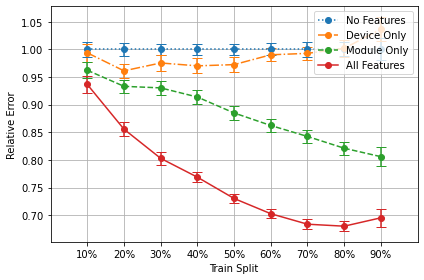

In [6]:
# Ablation: Input Features

def _ablation_features():
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    results.plots(
        ["Lr64", "device_only", "module_only", "Er64"],
        ax=ax, baseline=False, key="error", boxplot=False, normalize="Lr64",
        fmt=["o:", "o-.", "o--", "o-"], stderr=True,
        labels={
            "Lr64": "No Features",
            "device_only": "Device Only",
            "module_only": "Module Only",
            "Er64": "All Features"
        })
    ax.set_ylabel("Relative Error")
    fig.tight_layout()
    fig.savefig("figures/feature_ablation.png", dpi=300)

_ablation_features()

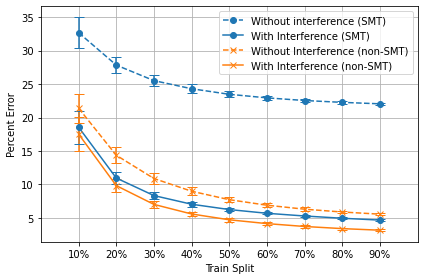

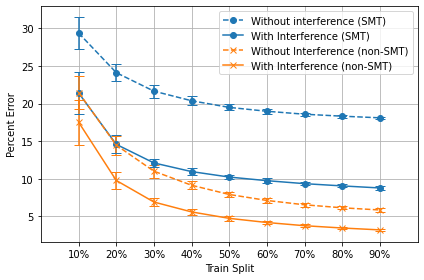

In [8]:
# 2-way, different datasets

def _interference_comparisons():
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    results.plots(
        ["Er64", "Is1", "e.if.mc", "if.mc"], ax=ax, baseline=False,
        boxplot=False, key="interference", fmt=['o--', 'o-', 'x--', 'x-'],
        colors=['C0', 'C0', 'C1', 'C1'], labels={
            "Er64": "Without interference (SMT)",
            "Is1": "With Interference (SMT)",
            "e.if.mc": "Without Interference (non-SMT)",
            "if.mc": "With Interference (non-SMT)"
        })
    fig.tight_layout()
    fig.savefig("figures/interference_2way.png", dpi=300)

    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    results.plots(
        ["e.if3", "if3", "e.if3.mc", "if3.mc"], ax=ax, baseline=False,
        boxplot=False, key="interference", fmt=['o--', 'o-', 'x--', 'x-'],
        colors=['C0', 'C0', 'C1', 'C1'], labels={
            "e.if3": "Without interference (SMT)",
            "if3": "With Interference (SMT)",
            "e.if3.mc": "Without Interference (non-SMT)",
            "if3.mc": "With Interference (non-SMT)"
        })
    fig.tight_layout()
    fig.savefig("figures/interference_3way.png", dpi=300)

_interference_comparisons()

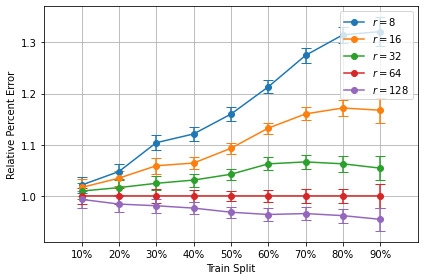

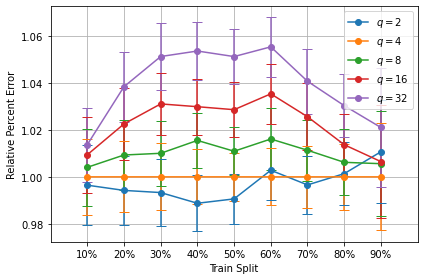

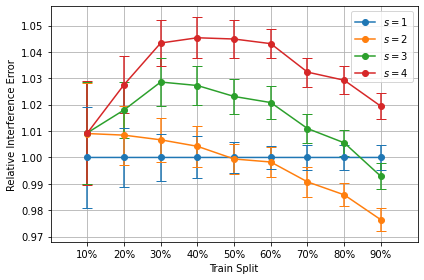

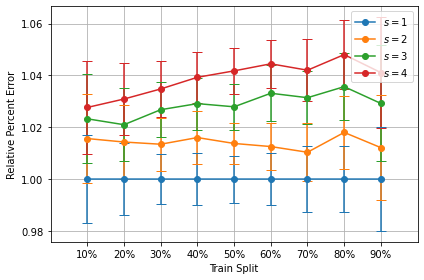

In [9]:
# Ablation: Embedding Dimension

_ablation_kwargs = {"stderr": True, "baseline": False, "boxplot": False}

def _ablations():
    embedding_r = [8, 16, 32, 64, 128]
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    results.plots(
        ["Er{}".format(r) for r in embedding_r],
        ax=ax, normalize="Er64", labels={
            "Er{}".format(r): "$r={}$".format(r) for r in embedding_r
        }, **_ablation_kwargs)
    ax.set_ylabel("Relative Percent Error")
    fig.tight_layout()
    fig.savefig("figures/ablations_r.png", dpi=300)

    embedding_q = [2, 4, 8, 16, 32]
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    results.plots(
        ["Eq{}".format(r) for r in embedding_q],
        ax=ax, normalize="Eq4", labels={
            "Eq{}".format(r): "$q={}$".format(r) for r in embedding_q
        }, **_ablation_kwargs)
    ax.set_ylabel("Relative Percent Error")
    fig.tight_layout()
    fig.savefig("figures/ablations_q.png", dpi=300)

    interference_i = [1, 2, 3, 4]
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    results.plots(
        ["Is{}".format(s) for s in interference_i],
        ax=ax, key="interference", normalize="Is1", labels={
            "Is{}".format(i): "$s={}$".format(i) for i in interference_i
        }, **_ablation_kwargs)
    ax.set_ylabel("Relative Interference Error")
    fig.tight_layout()
    fig.savefig("figures/ablations_s_if.png", dpi=300)

    interference_i = [1, 2, 3, 4]
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    results.plots(
        ["Is{}".format(s) for s in [1, 2, 3, 4]],
        ax=ax, key="error", normalize="Is1", labels={
            "Is{}".format(i): "$s={}$".format(i) for i in interference_i
        }, **_ablation_kwargs)
    ax.set_ylabel("Relative Percent Error")
    fig.tight_layout()
    fig.savefig("figures/ablations_s.png", dpi=300)

_ablations()

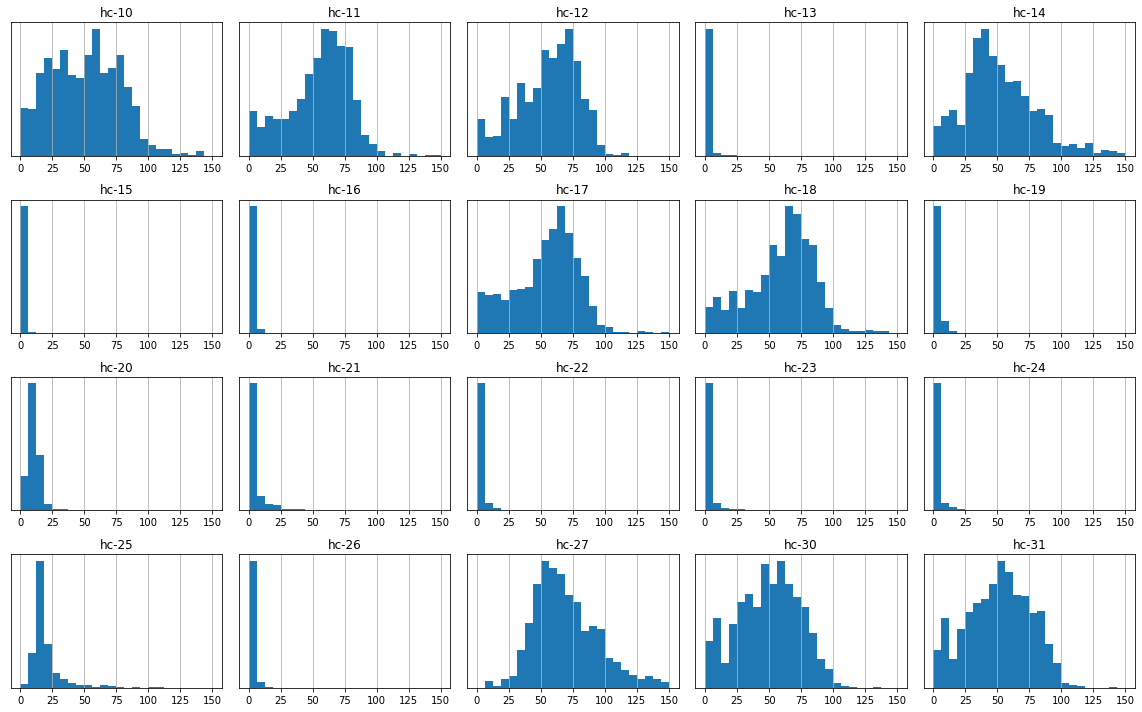

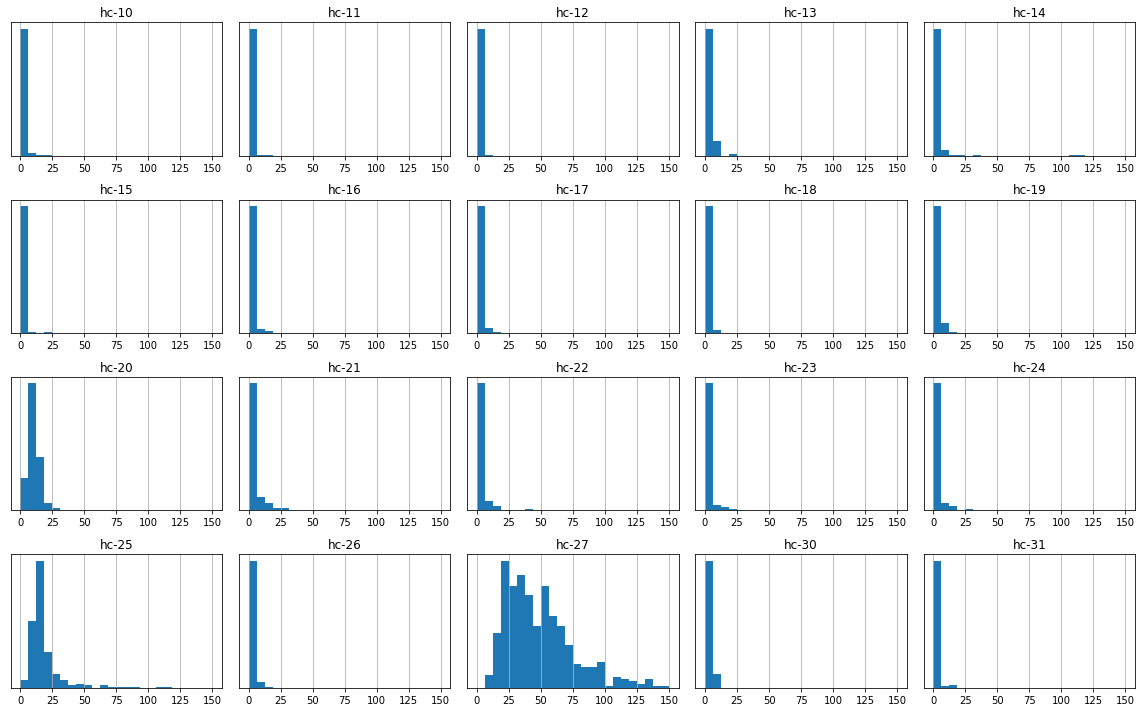

In [ ]:
def _interference_runtime(data, out):
    fig, axs = plt.subplots(4, 5, figsize=(16, 10))
    df = pd.read_csv(data)

    for rt, ax in zip(ds.runtimes, axs.reshape(-1)):
        ax.hist(
            100 * (np.exp(df[df["runtime"] == rt]["diff"]) - 1),
            np.linspace(0, 150, 25), density=True)
        ax.set_yticks([])
        ax.set_title(rt)
        ax.grid()

    fig.tight_layout()
    fig.savefig(out, dpi=300, bbox_inches='tight')

_interference_runtime(
    "data/if.csv", "figures/interference_runtime.png")
_interference_runtime(
    "data/if.mc.csv", "figures/interference_multicore.png")